In [1]:
from kl.homoscedastic_transformer import HomoscedasticTransformer as HomoTrans
from kl.utils import load_fx
import torch

window_size = 10
X, y, returns = load_fx(data_start=0, data_end=5000, window_size=window_size, shift=1, pair='GBPUSD')
X_new, y_new, returns_new = load_fx(data_start=0, data_end=6000, window_size=window_size, shift=1, pair='GBPUSD')

input_size = X.shape[1]
hidden_size = 50
latent_size = 10  # Latent space dimension

ht = HomoTrans(input_size=input_size, hidden_size=hidden_size, latent_size=latent_size, verbose=False)

X_Tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
X_Tensor_new = torch.tensor(X_new, dtype=torch.float32)
y_tensor_new = torch.tensor(y_new, dtype=torch.long)
# Fit the model and transform data
ht.fit(X_Tensor, epochs=100)
# Trnasform old and new data 
X_Homo_Tensor, p_value = ht.transform(X_Tensor)
reconstructed_data_np = X_Homo_Tensor.detach().numpy()

In [2]:
# reconstructed_data_np = reconstructed_data_np[5000:5500,:]

In [3]:
import numpy as np
np.savetxt("reconstructed_data_homo.csv", reconstructed_data_np, delimiter=",")

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
reconstructed_data_std = scaler.fit_transform(reconstructed_data_np)

np.savetxt("reconstructed_data_std.csv", reconstructed_data_std, delimiter=",")

print(f'X - >  Mean: {np.mean(X):.4f} , Std: {np.std(X):.4f}, Variance: {np.var(X):.4f}, Min: {np.min(X):.4f}, Max: {np.max(X):.4f}\n')

print(f'reconstructed Data - >  Mean: {np.mean(reconstructed_data_np):.4f} , Std: {np.std(reconstructed_data_np):.4f}, Variance: {np.var(reconstructed_data_np):.4f}, Min: {np.min(reconstructed_data_np):.4f}, Max: {np.max(reconstructed_data_np):.4f}')

print(f'reconstructed Data Standard Scaled- >  Mean: {np.mean(reconstructed_data_std):.4f} , Std: {np.std(reconstructed_data_std):.4f}, Variance: {np.var(reconstructed_data_std):.4f}, Min: {np.min(reconstructed_data_std):.4f}, Max: {np.max(reconstructed_data_std):.4f}')

X - >  Mean: -0.0000 , Std: 1.0000, Variance: 1.0000, Min: -2.5794, Max: 2.5965

reconstructed Data - >  Mean: 0.0019 , Std: 0.0656, Variance: 0.0043, Min: -0.4354, Max: 0.3370
reconstructed Data Standard Scaled- >  Mean: -0.0000 , Std: 1.0000, Variance: 1.0000, Min: -5.9656, Max: 5.5217


In [5]:
from statsmodels.stats.diagnostic import het_arch
from termcolor import colored
# Perform Engle's ARCH test for heteroscedasticity on the residuals
arch_test_resid = het_arch(reconstructed_data_np[:,0])

# Extract the test statistic and p-value
arch_stat_resid = arch_test_resid[0]
arch_p_value_resid = arch_test_resid[1]

print(f'ARCH Test Statistic: {arch_stat_resid}')
print(f'p-value: {arch_p_value_resid:.4f}')
if arch_p_value_resid > 0.05:
    print(colored("A p-value > 0.05 means that heteroscedasticity is no longer present in the residuals, indicating that VAE has successfully reduced it.",'red'))
else:
    print(f"VAE fail to reduce heteroscedasticity")

ARCH Test Statistic: 7.963654123500934
p-value: 0.6324
A p-value > 0.05 means that heteroscedasticity is no longer present in the residuals, indicating that VAE has successfully reduced it.


In [6]:
from arch import arch_model

# Rescale the data (multiply by 100)
scaled_data = reconstructed_data_np[:,0] * 100

# Fit the GARCH model with rescaled data
garch_model = arch_model(scaled_data, vol='Garch', p=1, q=1)
garch_rescaled_fitted = garch_model.fit(disp="off")

# Summarize the model
print(garch_rescaled_fitted.summary())


# Forecasting future volatility with rescaled data
forecast = garch_rescaled_fitted.forecast(horizon=5)
forecast_variance_rescaled = forecast.variance[-1:] / 100  # Scale back
print(forecast_variance_rescaled)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -17016.7
Distribution:                  Normal   AIC:                           34041.5
Method:            Maximum Likelihood   BIC:                           34067.5
                                        No. Observations:                 4990
Date:                Fri, Sep 20 2024   Df Residuals:                     4989
Time:                        00:59:50   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1551      0.104      1.496      0.135 [-4.80

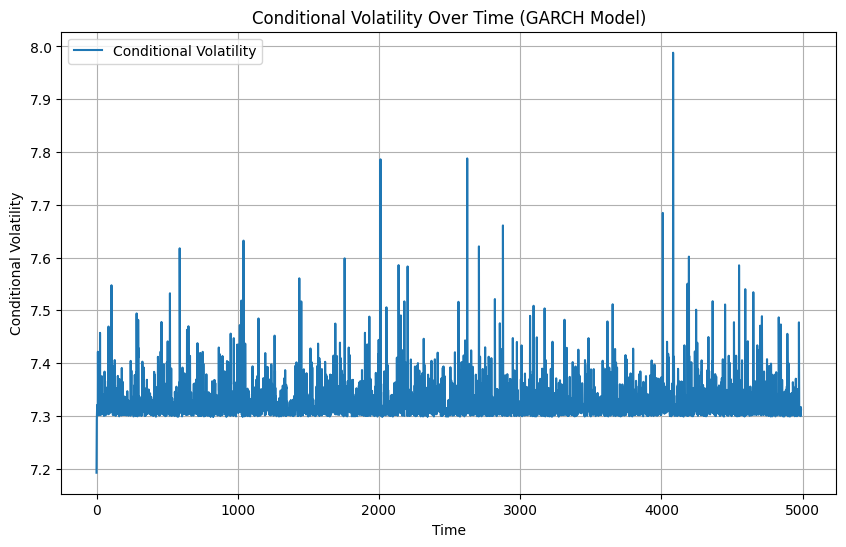

In [7]:
import matplotlib.pyplot as plt
# Plot the conditional volatility over time (variance over time)
plt.figure(figsize=(10, 6))
# Plot the conditional volatility (square root of variance)
conditional_volatility = garch_rescaled_fitted.conditional_volatility
plt.plot(garch_rescaled_fitted.conditional_volatility, label='Conditional Volatility')
plt.title('Conditional Volatility Over Time (GARCH Model)')
plt.xlabel('Time')
plt.ylabel('Conditional Volatility')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from kl.dichotomy_vae import DichotomyVAE
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# Example usage for fitting and transforming data
input_dim = X.shape[1]
vae_model = DichotomyVAE(input_dim=input_dim, output_dim=input_dim, latent_dim=2, num_classes=2, loss_total=False, verbose=True)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=5000)


#standart scaling
X_Homo_Tensor = scaler.fit_transform(X_Homo_Tensor)
# back to tensor because return numpy
X_Homo_Tensor = torch.tensor(X_Homo_Tensor, dtype=torch.float)

# Create a DataLoader for batching
batch_size = 64
dataset = TensorDataset(X_Homo_Tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Fit and transform
vae_model.fit(dataloader, optimizer, scheduler, num_epochs=5000, beta=1, lambda_class=1)

# Transform new data
# x_new = torch.tensor(X_new, dtype=torch.float32)
x_reconstructed, latent_representation, predicted_class = vae_model.transform(X_Homo_Tensor)  

Using MPS (Apple Silicon) for GPU acceleration
Epoch 1, kl: 7.4540, class: 0.7100, lr: 0.001000
Epoch 101, kl: 786.4409, class: 0.5887, lr: 0.000980


In [ ]:
x_reconstructed_np = x_reconstructed.detach().numpy()
np.savetxt("x_reconstructed_np.csv", x_reconstructed_np, delimiter=",")

predicted_class_np = predicted_class.detach().numpy()
np.savetxt("predicted_class_np.csv", predicted_class_np, delimiter=",")